<a href="https://colab.research.google.com/github/FGalvao77/Deteccao-de-cancer-de-mama-com-Deep-Learning/blob/main/Detec%C3%A7%C3%A3o_de_c%C3%A2ncer_de_mama_com_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Detecção de _câncer de mama_ com `Deep Learning`**
---
---

<br>

**Dataset (x-ray image) of:**

- https://www.kaggle.com/aryashah2k/breast-ultrasound-images-dataset

In [ ]:
!unzip /content/drive/MyDrive/breast_cancerXray.zip 

Archive:  /content/drive/MyDrive/breast_cancerXray.zip
  inflating: breast_cancerXray/Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: breast_cancerXray/Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: breast_cancerXray/Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: breast_cancerXray/Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: breast_cancerXray/Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: breast_cancerXray/Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: breast_cancerXray/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: breast_cancerXray/Dataset_BUSI_with_GT/benign/benign (101).png  
  inflating: breast_cancerXray/Dataset_BUSI_with_GT/benign/benign (101)_mask.png  
  inflating: breast_cancerXray/Dataset_BUSI_with_GT/benign/benign (102).png  
  inflating: breast_cancerXray/Dataset_BUSI_with_GT/benign/benign (102)_mask.png  
  inflating: breast_cancerXray/Dataset_BUSI_with_GT/benign/be

In [27]:
import os
import cv2
import numpy as np
# import tensorflow as tf
from tensorflow import keras as tfk
import matplotlib.pyplot as plt
import seaborn as sns

from keras import layers, optimizers
# from tensorflow.keras.applications import ResNet50
from keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

%matplotlib inline
plt.style.use('ggplot')

In [3]:
directory_imgs = '/content/Dataset_BUSI_with_GT'
print(f'Path: {os.listdir(directory_imgs)}')

Path: ['benign', 'malignant', 'normal']


In [4]:
for directory, subfolders, files in os.walk(directory_imgs):
    for image in files:
        if '_mask' in str(image):
            local = directory.replace('\\', '/') + '/' + image
            os.remove(local)

In [5]:
img_generator = ImageDataGenerator(rescale=1.0/255)

In [6]:
train_gen = img_generator.flow_from_directory(
    batch_size=50,
    directory=directory_imgs,
    shuffle=True,
    target_size=(256, 256),
    class_mode='categorical',
    subset='training'
)

Found 780 images belonging to 3 classes.


In [7]:
print(
    f'Images: {780}',
    f' | Run batches: {780/train_gen.batch_size}' # f' | Run batches: {780/50}'
)

Images: 780  | Run batches: 15.6


In [8]:
img_train, class_train = next(train_gen)

img_train.shape

(50, 256, 256, 3)

In [9]:
class_train[15:30]

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [10]:
classes = {
    0: 'normal',
    1: 'malignant', 
    2: 'benign'
}

classes 

{0: 'normal', 1: 'malignant', 2: 'benign'}

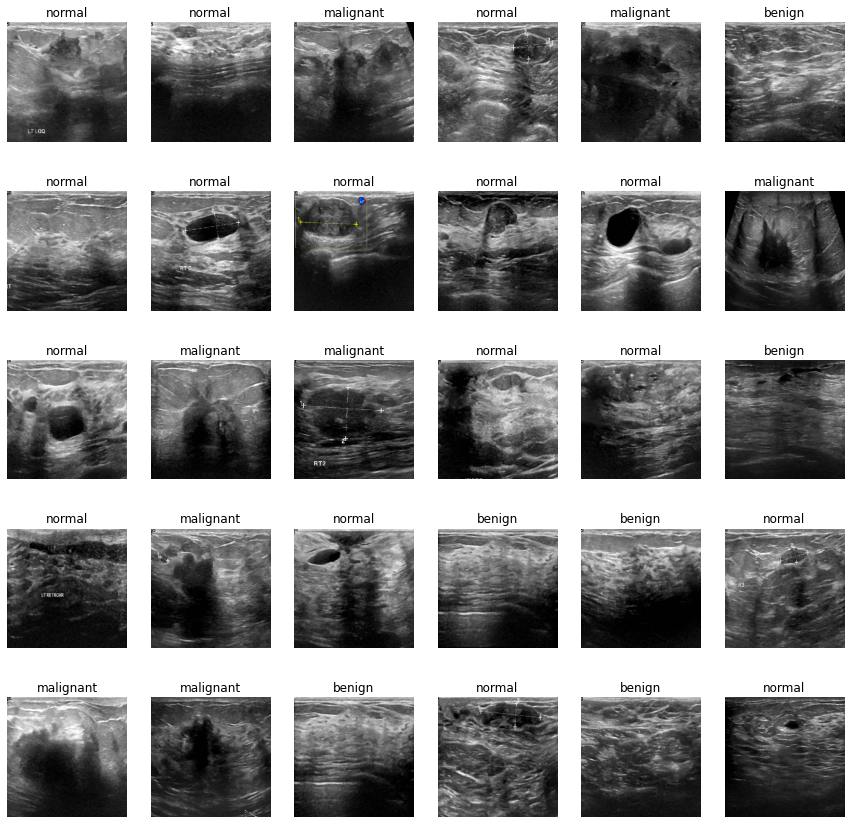

In [11]:
fig, axes = plt.subplots(5, 6, figsize=(15, 15))
axes = axes.ravel()

for loop in np.arange(0, 30):
    axes[loop].imshow(img_train[loop])
    axes[loop].set_title(classes[np.argmax(class_train[loop])])
    axes[loop].axis('off')

plt.subplots_adjust(wspace=0.2)

In [12]:
model_baseline = tfk.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_tensor=Input(shape=(256, 256, 3))
)

model_baseline.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

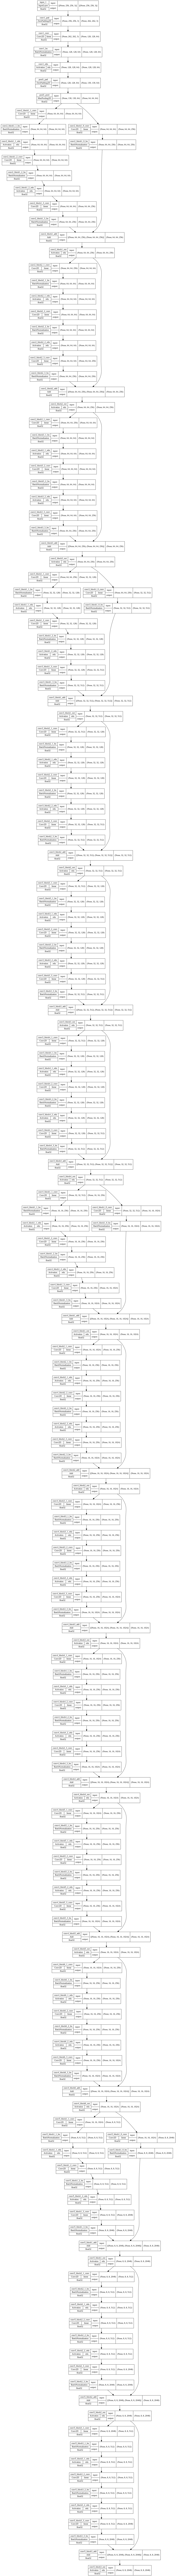

In [13]:
tfk.utils.plot_model(
    model_baseline,
    to_file='model_baseline.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

In [14]:
len(model_baseline.layers)

175

In [15]:
for layer_ in model_baseline.layers[:-10]:
    layer_.trainable=False

In [16]:
mdl_init = model_baseline.output

mdl_init = AveragePooling2D()(mdl_init)
mdl_init = Flatten()(mdl_init)
mdl_init = Dense(256, activation='relu')(mdl_init)
mdl_init = Dropout(0.2)(mdl_init)
mdl_init = Dense(256, activation='relu')(mdl_init)
mdl_init = Dropout(0.2)(mdl_init)
mdl_init = Dense(3, activation='softmax')(mdl_init)

model = Model(inputs=model_baseline.input, outputs=mdl_init)
model.compile(loss='categorical_crossentropy',
              optimizer=tfk.optimizers.RMSprop(learning_rate=1e-4, decay=1e-6),
              metrics=['accuracy']
              )

In [20]:
saving_net = ModelCheckpoint(filepath='weights.hdf5', save_best_only=True)

train_gen = img_generator.flow_from_directory(
    batch_size=50,
    directory=directory_imgs,
    shuffle=True,
    target_size=(256, 256),
    class_mode='categorical',
    subset='training'
)

Found 780 images belonging to 3 classes.


In [21]:
es = tfk.callbacks.EarlyStopping(
    monitor='loss', min_delta=0, patience=10, 
    mode='min', restore_best_weights=True
)

In [22]:
history = model.fit(
    train_gen,
    epochs=50,
    callbacks=[saving_net, es]
)

Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 1.1034 - accuracy: 0.5038 

16/16 [==============================] - 193s 12s/step - loss: 1.1034 - accuracy: 0.5038
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 0.9985 - accuracy: 0.5462 

16/16 [==============================] - 185s 12s/step - loss: 0.9985 - accuracy: 0.5462
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 0.9384 - accuracy: 0.5795 

16/16 [==============================] - 186s 12s/step - loss: 0.9384 - accuracy: 0.5795
Epoch 4/50
16/16 [==============================] - ETA: 0s - loss: 0.9091 - accuracy: 0.5910 

16/16 [==============================] - 191s 12s/step - loss: 0.9091 - accuracy: 0.5910
Epoch 5/50
16/16 [==============================] - ETA: 0s - loss: 0.8369 - accuracy: 0.6449 

16/16 [==============================] - 185s 12s/step - loss: 0.8369 - accuracy: 0.6449
Epoch 6/50
16/16 [==============================] - ETA: 0s - loss: 0.8372 - accuracy: 0.6282 

16/16 [==============================] - 186s 12s/step - loss: 0.8372 - accuracy: 0.6282
Epoch 7/50
16/16 [==============================] - ETA: 0s - loss: 0.7930 - accuracy: 0.6603 

16/16 [==============================] - 188s 12s/step - loss: 0.7930 - accuracy: 0.6603
Epoch 8/50
16/16 [==============================] - ETA: 0s - loss: 0.7682 - accuracy: 0.6603 

16/16 [==============================] - 185s 12s/step - loss: 0.7682 - accuracy: 0.6603
Epoch 9/50
16/16 [==============================] - ETA: 0s - loss: 0.7378 - accuracy: 0.6872 

16/16 [==============================] - 186s 12s/step - loss: 0.7378 - accuracy: 0.6872
Epoch 10/50
16/16 [==============================] - ETA: 0s - loss: 0.7431 - accuracy: 0.6615 

16/16 [==============================] - 186s 12s/step - loss: 0.7431 - accuracy: 0.6615
Epoch 11/50
16/16 [==============================] - ETA: 0s - loss: 0.7132 - accuracy: 0.6923 

16/16 [==============================] - 184s 11s/step - loss: 0.7132 - accuracy: 0.6923
Epoch 12/50
16/16 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.6974 

16/16 [==============================] - 191s 12s/step - loss: 0.6926 - accuracy: 0.6974
Epoch 13/50
16/16 [==============================] - ETA: 0s - loss: 0.6869 - accuracy: 0.6987 

16/16 [==============================] - 185s 12s/step - loss: 0.6869 - accuracy: 0.6987
Epoch 14/50
16/16 [==============================] - ETA: 0s - loss: 0.6724 - accuracy: 0.7282 

16/16 [==============================] - 186s 12s/step - loss: 0.6724 - accuracy: 0.7282
Epoch 15/50
16/16 [==============================] - ETA: 0s - loss: 0.6065 - accuracy: 0.7346 

16/16 [==============================] - 187s 12s/step - loss: 0.6065 - accuracy: 0.7346
Epoch 16/50
16/16 [==============================] - ETA: 0s - loss: 0.6157 - accuracy: 0.7359 

16/16 [==============================] - 184s 11s/step - loss: 0.6157 - accuracy: 0.7359
Epoch 17/50
16/16 [==============================] - ETA: 0s - loss: 0.5862 - accuracy: 0.7397 

16/16 [==============================] - 186s 12s/step - loss: 0.5862 - accuracy: 0.7397
Epoch 18/50
16/16 [==============================] - ETA: 0s - loss: 0.6001 - accuracy: 0.7410 

16/16 [==============================] - 184s 11s/step - loss: 0.6001 - accuracy: 0.7410
Epoch 19/50
16/16 [==============================] - ETA: 0s - loss: 0.5383 - accuracy: 0.7744 

16/16 [==============================] - 184s 11s/step - loss: 0.5383 - accuracy: 0.7744
Epoch 20/50
16/16 [==============================] - ETA: 0s - loss: 0.5281 - accuracy: 0.7962 

16/16 [==============================] - 186s 12s/step - loss: 0.5281 - accuracy: 0.7962
Epoch 21/50
16/16 [==============================] - ETA: 0s - loss: 0.4818 - accuracy: 0.8090 

16/16 [==============================] - 182s 11s/step - loss: 0.4818 - accuracy: 0.8090
Epoch 22/50
16/16 [==============================] - ETA: 0s - loss: 0.4608 - accuracy: 0.8154 

16/16 [==============================] - 182s 11s/step - loss: 0.4608 - accuracy: 0.8154
Epoch 23/50
16/16 [==============================] - ETA: 0s - loss: 0.4820 - accuracy: 0.8000 

16/16 [==============================] - 181s 11s/step - loss: 0.4820 - accuracy: 0.8000
Epoch 24/50
16/16 [==============================] - ETA: 0s - loss: 0.4511 - accuracy: 0.8244 

16/16 [==============================] - 182s 11s/step - loss: 0.4511 - accuracy: 0.8244
Epoch 25/50
16/16 [==============================] - ETA: 0s - loss: 0.4540 - accuracy: 0.8205 

16/16 [==============================] - 181s 11s/step - loss: 0.4540 - accuracy: 0.8205
Epoch 26/50
16/16 [==============================] - ETA: 0s - loss: 0.3839 - accuracy: 0.8410 

16/16 [==============================] - 182s 11s/step - loss: 0.3839 - accuracy: 0.8410
Epoch 27/50
16/16 [==============================] - ETA: 0s - loss: 0.3656 - accuracy: 0.8564 

16/16 [==============================] - 182s 11s/step - loss: 0.3656 - accuracy: 0.8564
Epoch 28/50
16/16 [==============================] - ETA: 0s - loss: 0.4372 - accuracy: 0.8256 

16/16 [==============================] - 181s 12s/step - loss: 0.4372 - accuracy: 0.8256
Epoch 29/50
16/16 [==============================] - ETA: 0s - loss: 0.3502 - accuracy: 0.8615 

16/16 [==============================] - 181s 11s/step - loss: 0.3502 - accuracy: 0.8615
Epoch 30/50
16/16 [==============================] - ETA: 0s - loss: 0.4049 - accuracy: 0.8372 

16/16 [==============================] - 181s 11s/step - loss: 0.4049 - accuracy: 0.8372
Epoch 31/50
16/16 [==============================] - ETA: 0s - loss: 0.3023 - accuracy: 0.8872 

16/16 [==============================] - 185s 12s/step - loss: 0.3023 - accuracy: 0.8872
Epoch 32/50
16/16 [==============================] - ETA: 0s - loss: 0.2788 - accuracy: 0.8974 

16/16 [==============================] - 182s 11s/step - loss: 0.2788 - accuracy: 0.8974
Epoch 33/50
16/16 [==============================] - ETA: 0s - loss: 0.2705 - accuracy: 0.8910 

16/16 [==============================] - 182s 11s/step - loss: 0.2705 - accuracy: 0.8910
Epoch 34/50
16/16 [==============================] - ETA: 0s - loss: 0.3504 - accuracy: 0.8603 

16/16 [==============================] - 182s 11s/step - loss: 0.3504 - accuracy: 0.8603
Epoch 35/50
16/16 [==============================] - ETA: 0s - loss: 0.2939 - accuracy: 0.8910 

16/16 [==============================] - 181s 11s/step - loss: 0.2939 - accuracy: 0.8910
Epoch 36/50
16/16 [==============================] - ETA: 0s - loss: 0.2167 - accuracy: 0.9128 

16/16 [==============================] - 182s 12s/step - loss: 0.2167 - accuracy: 0.9128
Epoch 37/50
16/16 [==============================] - ETA: 0s - loss: 0.2582 - accuracy: 0.8949 

16/16 [==============================] - 181s 11s/step - loss: 0.2582 - accuracy: 0.8949
Epoch 38/50
16/16 [==============================] - ETA: 0s - loss: 0.2684 - accuracy: 0.8910 

16/16 [==============================] - 181s 11s/step - loss: 0.2684 - accuracy: 0.8910
Epoch 39/50
16/16 [==============================] - ETA: 0s - loss: 0.1567 - accuracy: 0.9423 

16/16 [==============================] - 181s 11s/step - loss: 0.1567 - accuracy: 0.9423
Epoch 40/50
16/16 [==============================] - ETA: 0s - loss: 0.3276 - accuracy: 0.8731 

16/16 [==============================] - 181s 11s/step - loss: 0.3276 - accuracy: 0.8731
Epoch 41/50
16/16 [==============================] - ETA: 0s - loss: 0.1654 - accuracy: 0.9295 

16/16 [==============================] - 181s 11s/step - loss: 0.1654 - accuracy: 0.9295
Epoch 42/50
16/16 [==============================] - ETA: 0s - loss: 0.2078 - accuracy: 0.9141 

16/16 [==============================] - 181s 11s/step - loss: 0.2078 - accuracy: 0.9141
Epoch 43/50
16/16 [==============================] - ETA: 0s - loss: 0.2591 - accuracy: 0.9179 

16/16 [==============================] - 181s 11s/step - loss: 0.2591 - accuracy: 0.9179
Epoch 44/50
16/16 [==============================] - ETA: 0s - loss: 0.1836 - accuracy: 0.9295 

16/16 [==============================] - 181s 11s/step - loss: 0.1836 - accuracy: 0.9295
Epoch 45/50
16/16 [==============================] - ETA: 0s - loss: 0.1917 - accuracy: 0.9321 

16/16 [==============================] - 181s 11s/step - loss: 0.1917 - accuracy: 0.9321
Epoch 46/50
16/16 [==============================] - ETA: 0s - loss: 0.2081 - accuracy: 0.9231 

16/16 [==============================] - 181s 11s/step - loss: 0.2081 - accuracy: 0.9231
Epoch 47/50
16/16 [==============================] - ETA: 0s - loss: 0.1429 - accuracy: 0.9397 

16/16 [==============================] - 181s 11s/step - loss: 0.1429 - accuracy: 0.9397
Epoch 48/50
16/16 [==============================] - ETA: 0s - loss: 0.1502 - accuracy: 0.9359 

16/16 [==============================] - 181s 11s/step - loss: 0.1502 - accuracy: 0.9359
Epoch 49/50
16/16 [==============================] - ETA: 0s - loss: 0.1599 - accuracy: 0.9346 

16/16 [==============================] - 181s 12s/step - loss: 0.1599 - accuracy: 0.9346
Epoch 50/50
16/16 [==============================] - ETA: 0s - loss: 0.1276 - accuracy: 0.9436 

16/16 [==============================] - 181s 11s/step - loss: 0.1276 - accuracy: 0.9436


In [41]:
# plt.figure(figsize=(15, 9))

# plt.plot(history.history['accuracy'])
# plt.plot(history.history['loss'])

# plt.title('Right & Wrong\n', 
#           {'fontsize': 14,'fontweight': 'bold'})
# plt.xlabel('epochs')
# plt.ylabel('Rate - Right X Wrong')
# plt.legend(['Accuracy', 'Loss']);

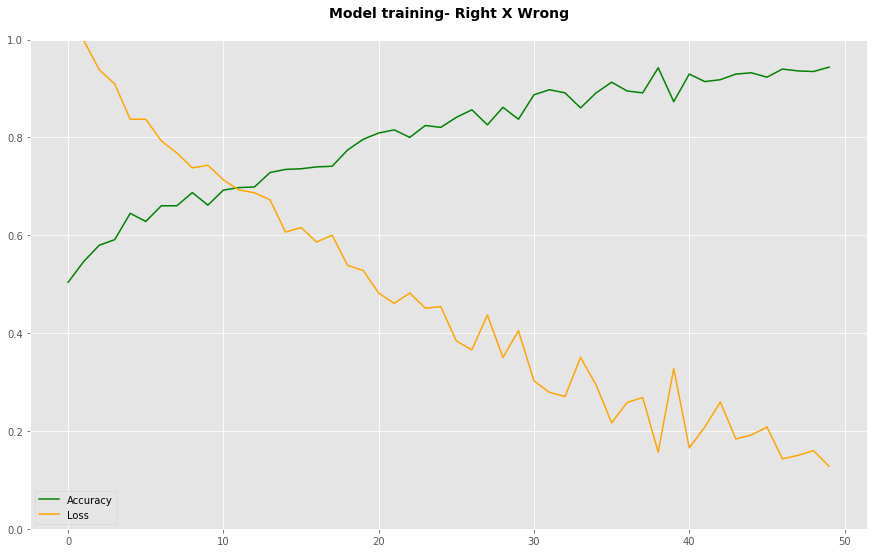

In [43]:
accuracy_ = history.history['accuracy']
loss_ = history.history['loss']

# size = len(history.epoch)

plt.figure(figsize=(15, 9)) 
plt.title(
    'Model training- Right X Wrong\n', 
    {'fontsize': 14,'fontweight': 'bold'}
)

plt.plot(range(len(history.epoch)), accuracy_, 'g', 
         label='Accuracy')
plt.plot(range(len(history.epoch)), loss_, 'orange', 
         label='Loss')

plt.legend(loc='lower left')
plt.gca().set_ylim(0, 1)
plt.grid(True)

plt.show();